In [1]:
import os
import sys

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm

from platypus.algorithms import EpsMOEA, NSGAIII, MOEAD
from ema_workbench.analysis import prim, cart, dimensional_stacking, parcoords
from ema_workbench import ema_logging, load_results, MultiprocessingEvaluator, Constraint, Scenario
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress, epsilon_nondominated, Convergence, rebuild_platypus_population


from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)

from ema_workbench.em_framework.optimization import to_problem

from SALib.analyze import sobol

from problem_formulation import get_model_for_problem_formulation

In [2]:
problem_formulation_id = 8
dike_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = [u.name for u in dike_model.uncertainties]
levers = [l.name for l in dike_model.levers]
ooi = [o.name for o in dike_model.outcomes]
ooi_dr3 = ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths']

# General Analysis for OOI of Dike Ring 3
Goals
* Understand the distribution of all the model OOIs 
* Determine the thresholds for the worse-case scenarios of the 2 OOI with primary priority of Dike Ring 3, namely **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths**

Steps
* Inspect the OOI distribution using: histogram and accumulative plots
* Identify threshold values for each OOI of Dike Ring 3

Results:
* **Dike Investment Costs**, **RfR Investment Costs** and **Evacuation Costs** are 0 in all experiments. This is logical since there is no policies applied, the cost of implementation should be 0.
* **Total Expected Number of Deaths** is rather low for about half of the times. The remaining times, it is evenly spread out to the tail of the distribution.
* The plots of the distributions of the OOI shows that for the status quo (i.e: no policy), the **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are relatively low, approximately 0, for more than half of the time. The remaining times, the values of these 2 OOIs are evenly distributed. The threshold for worse-case scenarios for these 2 OOIs are taken as the 90th value for the following reasons:
    * The remaining of the time when **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are high, their distributions are evenly spreaded out towards the tail of the distributions.
* **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are highly correlated.

In [3]:
# load experiment results
experiment, outcomes = load_results(os.path.join('experiment', 'pol0_sc500_8.tar.gz'))
df_outcomes = pd.DataFrame(outcomes)
df_outcomes.describe()

,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
count,20000.0,20000.0,20000.0,20000.000000,2.000000e+04,20000.000000
mean,0.0,0.0,0.0,1.573784,3.769750e+08,0.660572
std,0.0,0.0,0.0,1.118179,6.298548e+08,1.081872
min,0.0,0.0,0.0,0.043660,0.000000e+00,0.000000
25%,0.0,0.0,0.0,0.583102,0.000000e+00,0.000000
50%,0.0,0.0,0.0,1.745502,2.890244e+07,0.050463
75%,0.0,0.0,0.0,2.027489,4.443312e+08,0.828730
max,0.0,0.0,0.0,5.242905,2.594880e+09,3.313654


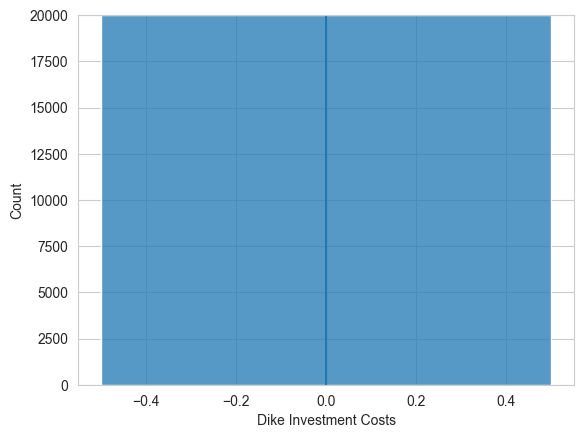

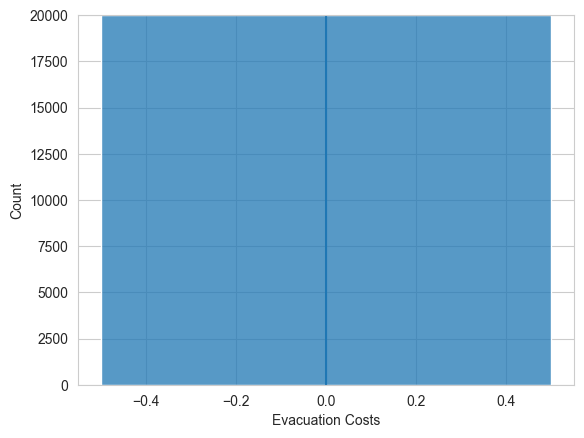

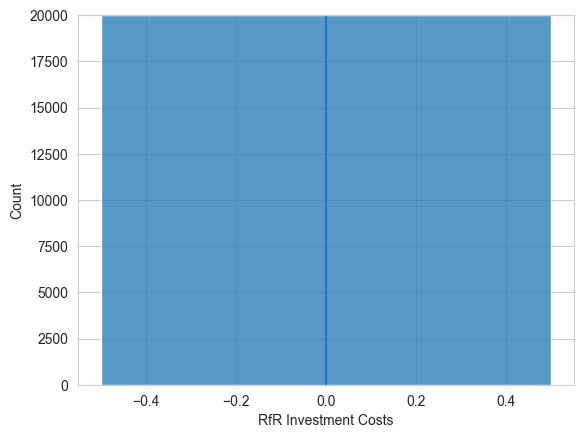

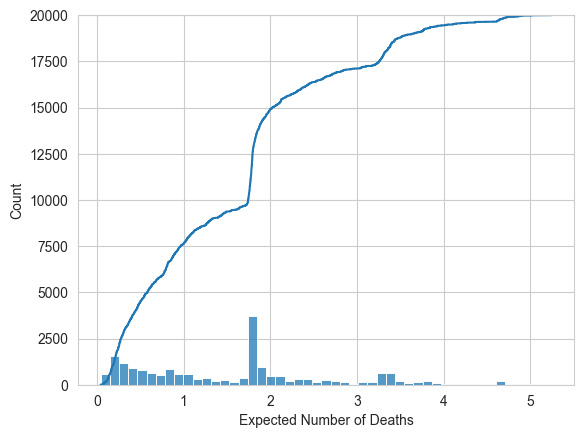

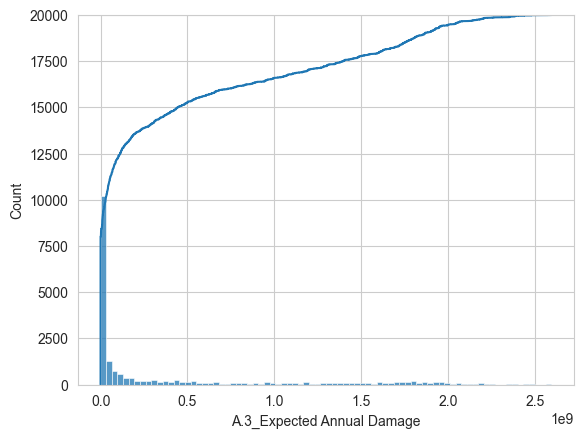

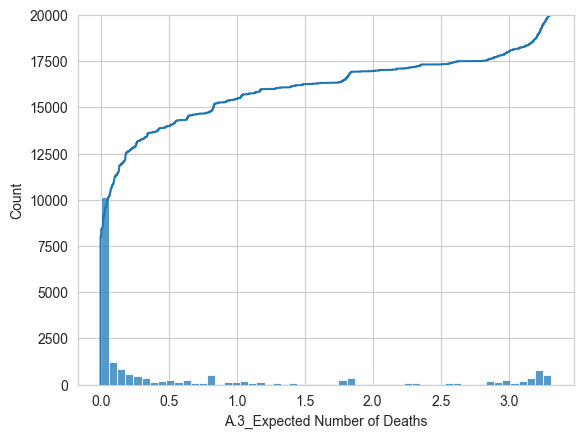

In [4]:
for o in ooi:
    sns.histplot(df_outcomes, x=o)
    sns.ecdfplot(df_outcomes, x=o, stat='count')
    plt.show()

The plots of the distributions of the OOI shows that for the status quo (i.e: no policy), the **Expected Number of Death**, **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are relatively low.

Since the primary OOIs of Dike Ring 3 are **A.3_Expected Annual Damage** and **A.3_Expected Annual Damage**, and not **Expected Number of Death**, these 2 primary OOIs will be used for Scenario Discovery.
 
The threshold for worse-case scenarios for these 2 primary OOIs are taken as their respective 90th value.

In [5]:
q_damage = 0.90
threshold_damage = df_outcomes['A.3_Expected Annual Damage'].quantile(q_damage)

q_death = 0.90
threshold_death = df_outcomes['A.3_Expected Number of Deaths'].quantile(q_death)

threshold_dict = {
    'A.3_Expected Annual Damage': threshold_damage,
    'A.3_Expected Number of Deaths': threshold_death
}

## Relationship between A.3_Expected Annual Damage and A.3_Expected Number of Deaths

The stat model shows that there is a strong linear relationship between **A.3_Expected Number of Deaths** and **A.3_Expected Annual Damage**. About 97% of the data points can be explained by this linear relationship (R-squared = 0.97).

In [6]:
X = sm.add_constant(df_outcomes['A.3_Expected Annual Damage'])
Y = df_outcomes['A.3_Expected Number of Deaths']
regress_model_ooi = sm.OLS(Y,X)
regress_result_ooi = regress_model_ooi.fit()
regress_result_ooi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     A.3_Expected Number of Deaths   R-squared:                       0.970
Model:                                       OLS   Adj. R-squared:                  0.970
Method:                            Least Squares   F-statistic:                 6.448e+05
Date:                           Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                                   17:53:42   Log-Likelihood:                 5086.0
No. Observations:                          20000   AIC:                        -1.017e+04
Df Residuals:                              19998   BIC:                        -1.015e+04
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0229      0.002     14.792      0.000       0.020       0.026
A.3_Expected Annual Damage  1.692e-09   2.11e-12    802.979      0.000    1.69e-09     1.7e-09
==============================================================================
Omnibus:                     4126.212   Durbin-Watson:                   0.453
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103248.264
Skew:                           0.374   Prob(JB):                         0.00
Kurtosis:                      14.106   Cond. No.                     8.55e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.55e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

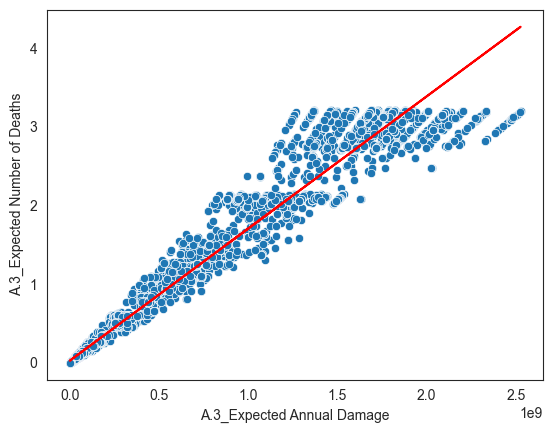

In [53]:
ax = plt.subplot()
y_graph = df_outcomes['A.3_Expected Annual Damage']*regress_result_ooi.params['A.3_Expected Annual Damage'] +  regress_result_ooi.params['const']
ax.plot(df_outcomes['A.3_Expected Annual Damage'], y_graph, color='r')
sns.scatterplot(df_outcomes, x='A.3_Expected Annual Damage', y='A.3_Expected Number of Deaths', ax=ax)
plt.show()

In [7]:
# # create figures for report - distributions
# fig, axes = plt.subplots(nrows=2, ncols=2, layout='constrained', figsize=(10,10))
# 
# y_graph = df_outcomes['A.3_Expected Annual Damage']*regress_result_ooi.params['A.3_Expected Annual Damage'] +  regress_result_ooi.params['const']
# axes[0][0].plot(df_outcomes['A.3_Expected Annual Damage'], y_graph, color='r')
# sns.scatterplot(df_outcomes, x='A.3_Expected Annual Damage', y='A.3_Expected Number of Deaths', ax=axes[0][0])
# 
# 
# for ax, key in zip([axes[0][1], axes[1][0], axes[1][1]], ['Expected Number of Deaths', *ooi_dr3]):
#     sns.histplot(df_outcomes, x=key, ax=ax)
#     sns.ecdfplot(df_outcomes, x=key, stat='count', ax=ax)
#     
# plt.savefig(os.path.join('img', 'distribution_0.png'))

# Sensitivity analysis

Goals
* Identify the uncertainties to which the 2 primary OOIs are most sensitive to

Steps
* Use Feature scoring analysis
* Use Sobol indices analysis

Results
* A.3_pfail has the most significant impact of the 2 primary OOIs of Dike Ring 3. This influence is mostly first order (i.e., the uncertainty has the impact by itself, not in combination with other uncertainties)
* A.1_pfail and A.2_pfail has some influence on the 2 OOIs of Dike Ring 3. These influence are much milder than that of A.3_pfail. Furthermore, these influences are mostly not first order (i.e., they must be combined with other uncertainties)


The sensitivity analysis is logical for two reasons. Firstly, since Dike Ring 3 is located in Zutphen, its failure probability should have the highest direct impacts on the 2 OOIs of Zutphen. Secondly, given that Dike Ring 1 and 2 are located directly upstream from Zutphen, it is probable that Zutphen will be impacted by their failures. Moreover, the fact that the set of uncertainties and their respective impacts on these 2 OOIs are similar is in accordance with the high correlation of these 2 OOIs.

## Feature scoring

Feature scoring analysis shows that:
* A.3_pfail has the most influence on the 2 OOIs of dike ring 3.
* additionally the uncertainties dictating the failure (A.1_pfail) of dike ring A.1 has some influences on the 2 OOIs of dike ring 3, albeit not as significant as A.3_pfail. 
* additionally the uncertainties dictating the failure (A.2_pfail) of dike ring A.2 has some influences on the 2 OOIs of dike ring 3, albeit not less significant than that of A.1_pfail.

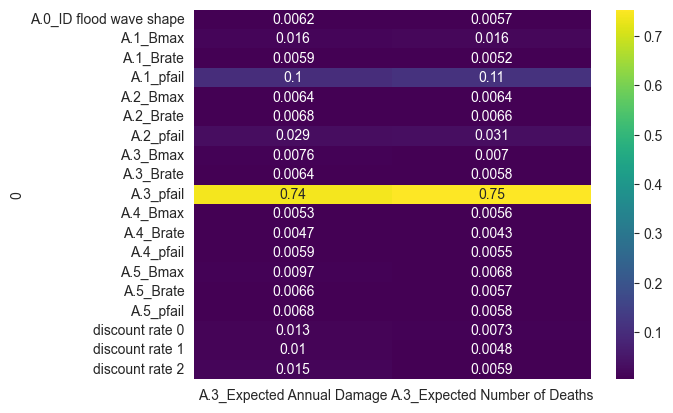

In [8]:
scores = feature_scoring.get_feature_scores_all(experiment[uncertainties], df_outcomes[ooi_dr3],
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True, cmap='viridis')
plt.show()

## Sobol Indices

Sobol Indices analysis shows that:
* A.3_pfail has the most influence on the 2 OOIs of dike ring 3. This impact is primarily first order,
* Additionaly the uncertainties dictating the failure of dike rings A.1 (A.1_pfail) and A.2 (A.2_pfail) also have some influences on the 2 OOIs of dike ring 3, albeit not as significant. These impacts are not primarily first order impacts, indicating that these uncertainties must be combined with other uncertainties to influence these OOIs.


****************************************************************************************************

A.3_Expected Annual Damage
                                   ST   ST_conf
A.0_ID flood wave shape  6.509944e-03  0.002595
A.1_Bmax                 3.407919e-02  0.020167
A.1_Brate                4.798540e-04  0.000763
A.1_pfail                2.020617e-01  0.066395
A.2_Bmax                 4.659265e-03  0.006720
A.2_Brate                8.779553e-07  0.000001
A.2_pfail                7.173255e-02  0.054135
A.3_Bmax                 0.000000e+00  0.000000
A.3_Brate                0.000000e+00  0.000000
A.3_pfail                9.785005e-01  0.113407
A.4_Bmax                 0.000000e+00  0.000000
A.4_Brate                0.000000e+00  0.000000
A.4_pfail                0.000000e+00  0.000000
A.5_Bmax                 0.000000e+00  0.000000
A.5_Brate                0.000000e+00  0.000000
A.5_pfail                0.000000e+00  0.000000
discount rate 0          9.516853e-03  0.002418
discou

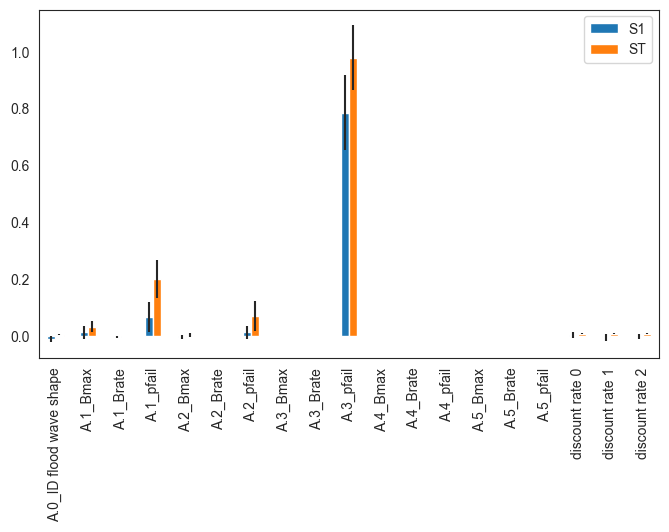


****************************************************************************************************

A.3_Expected Number of Deaths
                                   ST   ST_conf
A.0_ID flood wave shape  6.388476e-03  0.002780
A.1_Bmax                 2.977252e-02  0.015520
A.1_Brate                3.861901e-04  0.000636
A.1_pfail                2.007343e-01  0.065399
A.2_Bmax                 7.868565e-03  0.013884
A.2_Brate                9.642578e-07  0.000001
A.2_pfail                6.161656e-02  0.040778
A.3_Bmax                 0.000000e+00  0.000000
A.3_Brate                0.000000e+00  0.000000
A.3_pfail                9.723928e-01  0.107873
A.4_Bmax                 0.000000e+00  0.000000
A.4_Brate                0.000000e+00  0.000000
A.4_pfail                0.000000e+00  0.000000
A.5_Bmax                 0.000000e+00  0.000000
A.5_Brate                0.000000e+00  0.000000
A.5_pfail                0.000000e+00  0.000000
discount rate 0          0.000000e+00  0.000000
dis

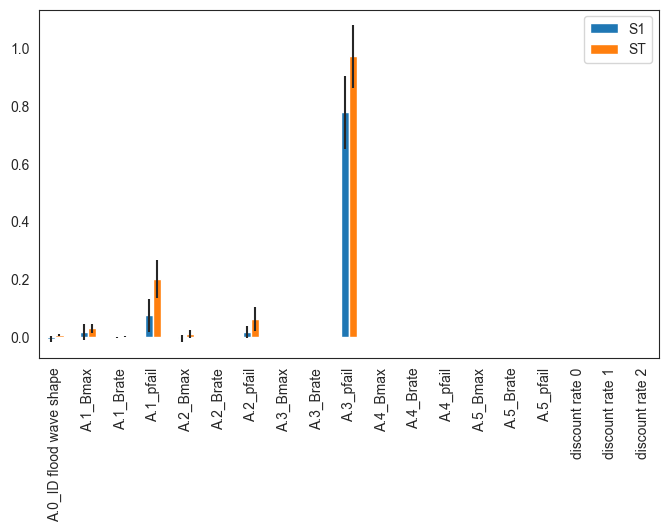

In [9]:
problem = get_SALib_problem(dike_model.uncertainties)
for key in ooi_dr3:
    print('\n' + '*'*100 + '\n')
    print(key)
    Si = sobol.analyze(problem, outcomes[key], calc_second_order=True, print_to_console=True)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    sns.set_style('white')
    fig, ax = plt.subplots(1)
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

In [10]:
# # create figure for report - sensitivity analysis
# fig, ax = plt.subplots(nrows=3, ncols=1, layout='constrained', figsize=(15,20))
# sns.set_style('white')
# 
# problem = get_SALib_problem(dike_model.uncertainties)
# for i, key in enumerate(ooi_dr3):
#     Si = sobol.analyze(problem, outcomes[key], calc_second_order=True, print_to_console=False)
#     Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
#     Si_df = pd.DataFrame(Si_filter, index=problem['names'])
#     
#     indices = Si_df[['S1','ST']]
#     err = Si_df[['S1_conf','ST_conf']]
#     
#     indices.plot.bar(yerr=err.values.T, ax=ax[i])
#     ax[i].set_title(f'Sobol indices - {key}')
#     
# sns.heatmap(scores, annot=True, cmap='viridis', ax=ax[2])
# ax[2].set_title(f'Feature scores - {ooi_dr3}')
# 
# plt.savefig(os.path.join('img', 'sensitivity_0.png'))

# Scenario discovery

Goals:
* Identify worse-case scenarios for the 2 primary OOIs of Dike Ring 3.

Steps:
* Perform different scenario discovery techniques to find the set of uncertainties and their value ranges that results in the 2 OOIs is above the 90th percentile values:
    * Dimensional stacking
    * PRIM 
    * CART 
* Identify the common set among these 3 techniques to derive the scenarios of interest

Results:
* The 3 techniques yield consistent results regarding the uncertainties causing the worse-case scenarios and their value ranges. So, 3 scenarios are selected, which are taken from box 1, box 2 and box 3 of the CART algorithm to be the scenarios to run optimization on. They are:

|           | box_1_max          | box_2_max         | box_3_max          |
|-----------|--------------------|-------------------|--------------------|
| A.3_pfail | 0.17164792865514755 | 0.17164792865514755 | 0.17164792865514755 |
| A.1_pfail | 0.3404737710952759 | 0.998965362086892 | 0.998965362086892  |
| A.2_pfail | 0.9992654966190456 | 0.50148606300354  | 0.9992654966190456 | 


## Dimensional stacking

Results show that:
* For **A.3_Expected Number of Deaths** falls into the 90th percentile when:
    * A.1_pfail is in the range 0.33 and 1.0
    * A.3_pfail is in the range 0.33 and 0
    * A.2_pfail is in the range 0.33 and 1.0
* For **A.3_Expected Annual Damage** falls into the 90th percentile when:
    * A.1_pfail is in the range 0.33 and 1.0
    * discount rate 2 is in 1-4
    * A.3_pfail is in the range 0.33 and 0
    * discount rate 0 is in 1-4 


****************************************************************************************************

A.3_Expected Annual Damage


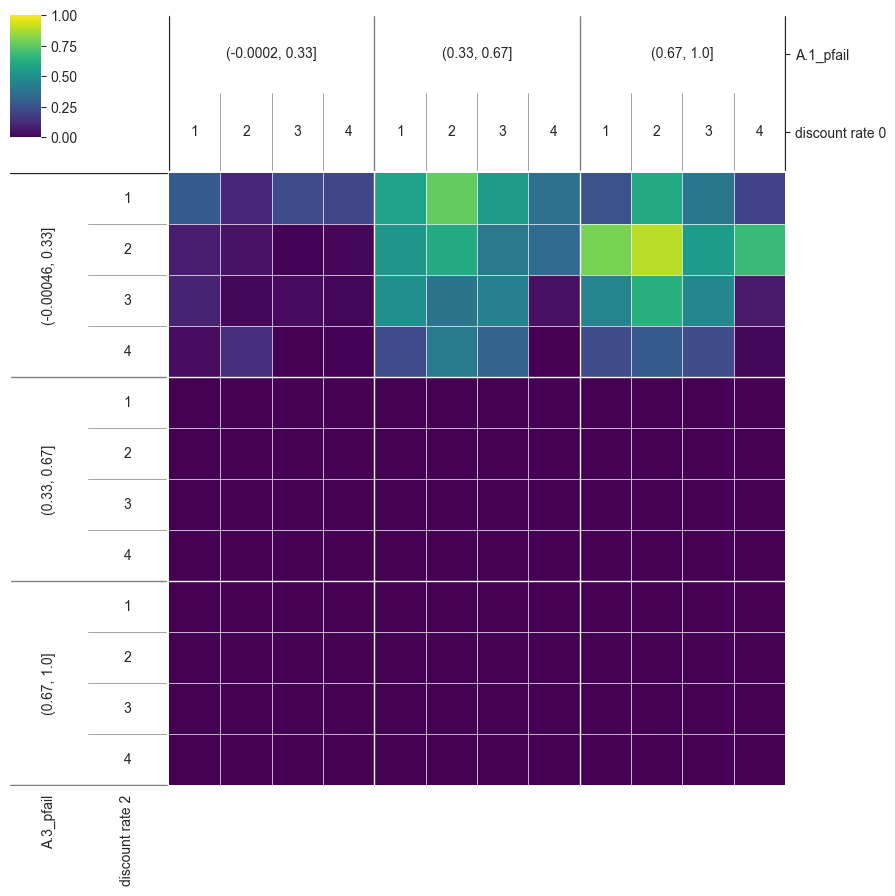


****************************************************************************************************

A.3_Expected Number of Deaths


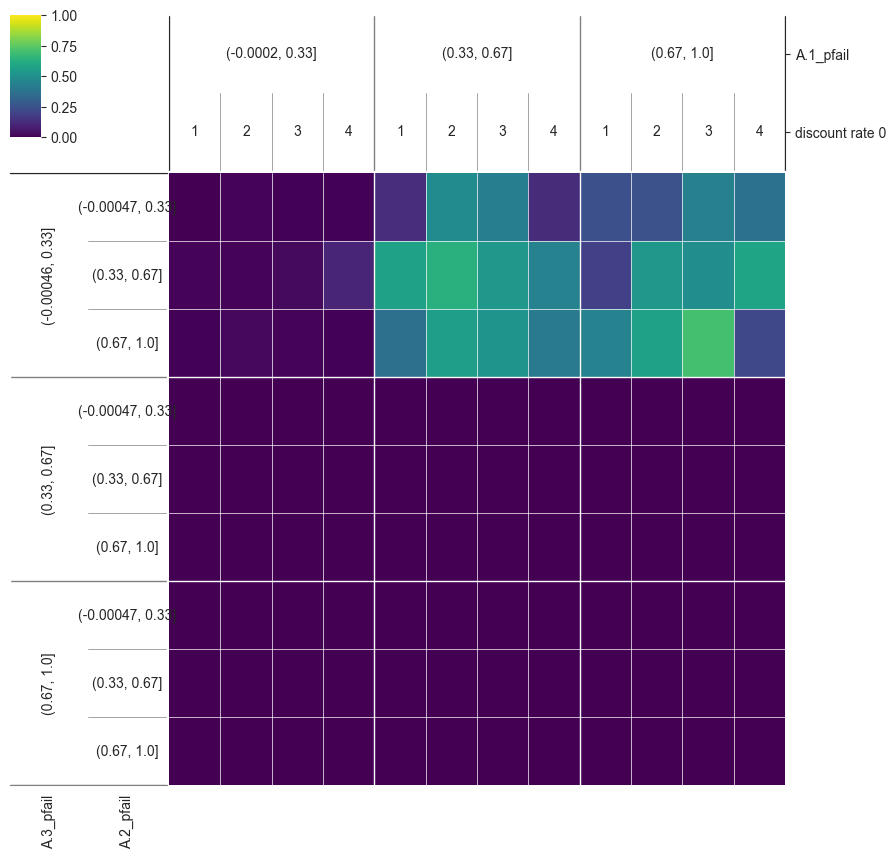

In [11]:
x = experiment[uncertainties]
for key in ooi_dr3:
    print('\n' + '*'*100 + '\n')
    print(key)
    y = (df_outcomes[key] > threshold_dict[key]).values
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3, bin_labels=True)
    plt.show()

## PRIM

Steps
* Use PRIM to find scenarios where **A.3_Expected Number of Death** is above the accepted threshold
* Use PRIM to find scenarios where **A.3_Expected Number of Death** and **A.3_Expected Annual Damage** is above the accepted threshold

Results

For both **A.3_Expected Number of Death** and **A.3_Expected Annual Damage**:
* A.2_pfail is between 0.088, 1
* A.1_pfail is between 0.38, 1
* A.3_pfail is between 0, 0.16
* A.3_pfail is the most influential, followed by A.1_pfail, then by A.2_pfail.

For **A.3_Expected Annual Damage**, discount rate 0, among {1.5, 2.5. 3.5} has a not too significan influence compared to A.3_pfail, A.1_pfail and A.2_pfail.

### A.3_Expected Number of Death

In [12]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = (df_outcomes['A.3_Expected Number of Deaths'] > threshold_death).values

prim_alg_0_death = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1_0_death = prim_alg_0_death.find_box()

[MainProcess/INFO] 20000 points remaining, containing 1988 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.07295, coverage: 0.7339034205231388, density: 1.0 restricted_dimensions: 3


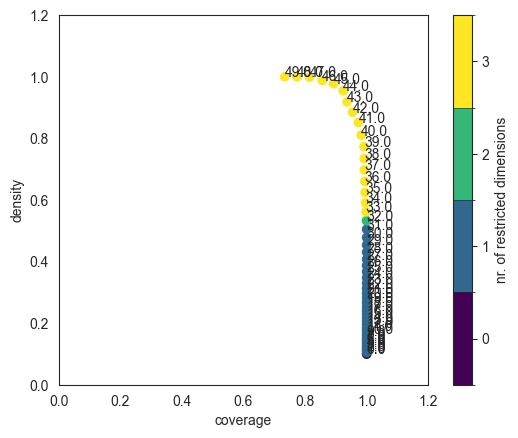

In [13]:
box1_0_death.show_tradeoff(annotated=True)
plt.show()

Select the PRIM box where density and coverage are above 0.7. The box with the highest density and coverage values meeting these requirementes is selected.

[<Figure size 640x480 with 1 Axes>]

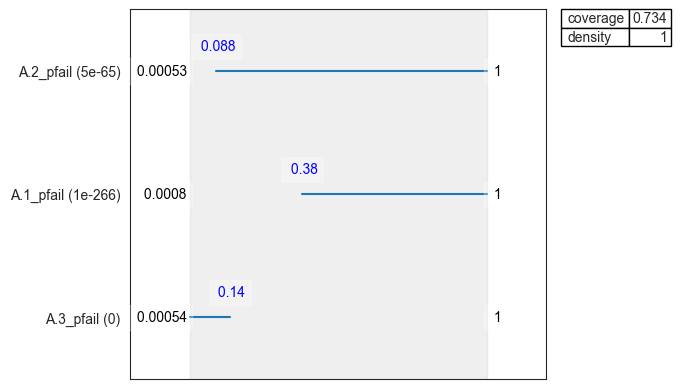

In [14]:
box1_0_death_index = box1_0_death.peeling_trajectory[(box1_0_death.peeling_trajectory.density >= 0.7) & (box1_0_death.peeling_trajectory.coverage >= 0.7)].index
point = int(box1_0_death_index[-1])
box1_0_death.inspect(point, style='graph')

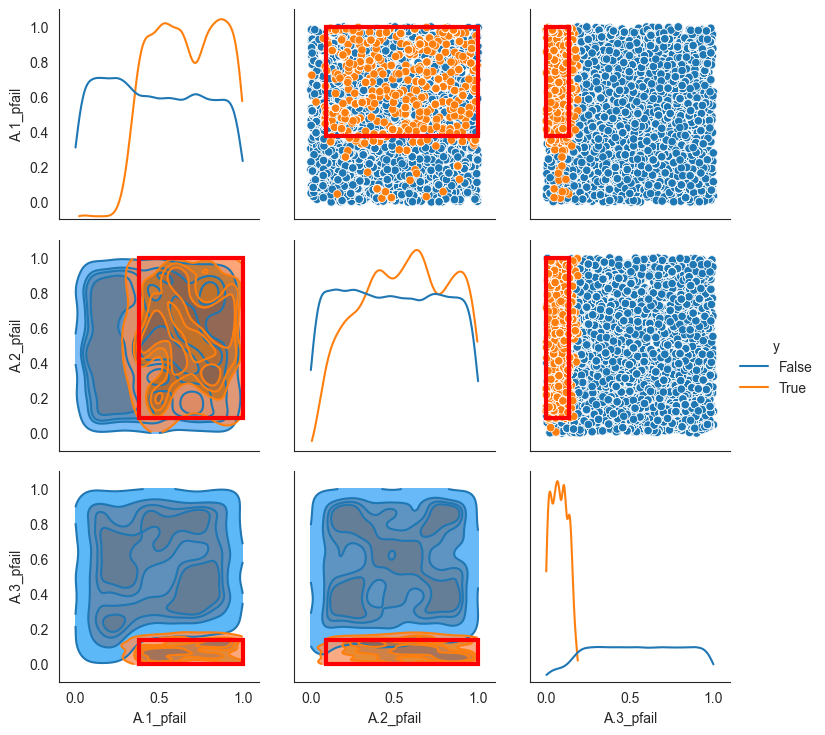

In [15]:
box1_0_death.show_pairs_scatter(point)

In [16]:
box1_0_death.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '123.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '120.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] resample 4
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Val

,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
A.3_pfail,100.0,100.0
A.5_Bmax,50.0,50.0
A.0_ID flood wave shape,40.0,40.0
A.3_Bmax,10.0,10.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.1_Bmax,0.0,0.0


### A.3_Expected Number of Death and A.3_Expected Annual Damage

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = ((df_outcomes['A.3_Expected Number of Deaths'] > threshold_death) & (df_outcomes['A.3_Expected Annual Damage'] > threshold_damage)).values

prim_alg_0_death_damage = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1_0_death_damage = prim_alg_0_death_damage.find_box()

[MainProcess/INFO] 20000 points remaining, containing 1641 cases of interest
[MainProcess/INFO] mean: 0.9755381604696673, mass: 0.0511, coverage: 0.6075563680682511, density: 0.9755381604696673 restricted_dimensions: 6


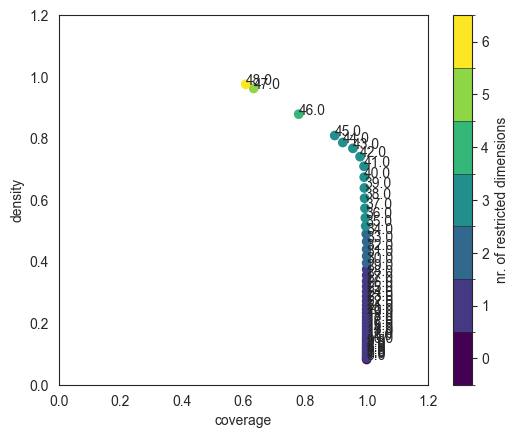

In [18]:
box1_0_death_damage.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

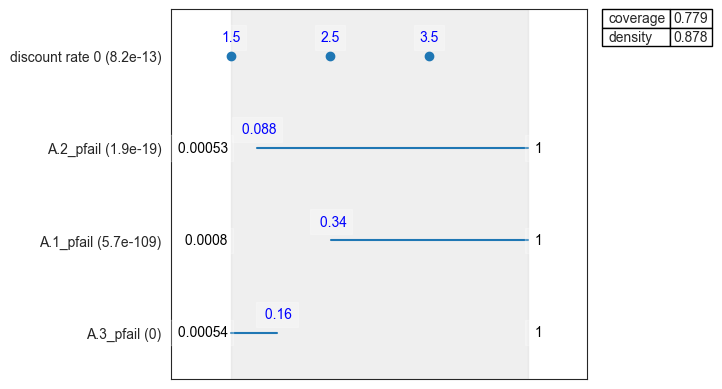

In [19]:
box1_0_death_damage_index = box1_0_death_damage.peeling_trajectory[(box1_0_death_damage.peeling_trajectory.density >= 0.7) & (box1_0_death_damage.peeling_trajectory.coverage >= 0.7)].index
point = int(box1_0_death_damage_index[-1])
box1_0_death_damage.inspect(point, style='graph')

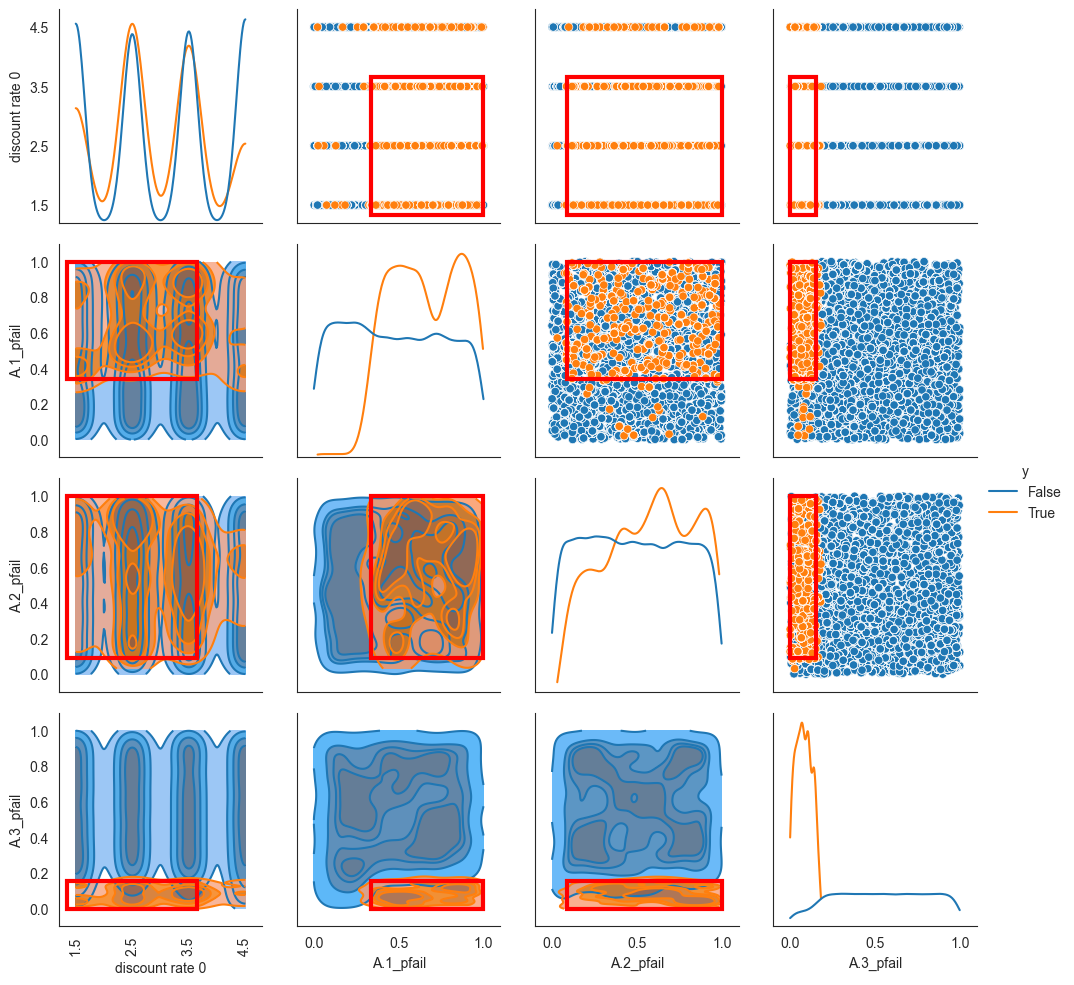

In [20]:
box1_0_death_damage.show_pairs_scatter(point)

In [32]:
# # create figure for report - scenario discovery prim
# 
# fig, axes = plt.subplots(nrows=2, ncols=1, layout='constrained', figsize=(7, 7))
# 
# point = int(box1_0_death_index[-1])
# box1_0_death.inspect(point, style='graph', ax=axes[0])
# axes[0].set_title(f'PRIM - {ooi_dr3[1]}')
# 
# point = int(box1_0_death_damage_index[-1])
# box1_0_death_damage.inspect(point, style='graph', ax=axes[1])
# axes[1].set_title(f'PRIM - {ooi_dr3[1]} and {ooi_dr3[0]}')
# 
# plt.savefig(os.path.join('img', 'prim_0.png'))

In [36]:
# # create figure for report - scenario discovery dimensional stacking
# fig = plt.figure(layout='constrained', figsize=(5, 5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])
# 
# for i, key in enumerate(ooi_dr3):
#     
#     y = (df_outcomes[key] > threshold_dict[key]).values
#     
#     subfigs[i] = dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3, bin_labels=True)
#     subfigs[i].suptitle(f'Dimensional Stacking - {key}', fontsize='x-large')
#     
#     plt.savefig(os.path.join('img', f'dimensional_stacking_0_{i}.png'))

## Cart

The results show that the uncertainties resulting in the 2 OOIs values to be above the 90th threshold are: A.3_pfail, A.1_pfail, A.1_pfail. These uncertainties are consistent with the sensititivy analysis above.

There are 5 scenarios, corresponding to the 5 leaf nodes of the CART, where the 2 OOIs values are above the 90th threshold. Among these 5 boxes, the ranges in box 1, box 2 and box 3 are in accordance with the 2 scenario discovery results from dimensional stacking and PRIM box above. So, the upper bound of box 1, box 2 and box 3 are selected to be the scenarios to find optimization for,

### A.3_Expected Number of Death

In [33]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = (df_outcomes['A.3_Expected Number of Deaths'] > threshold_death).values

cart_alg_0_death = cart.CART(x, y, 0.05)
cart_alg_0_death.build_tree()
cart_alg_0_death.boxes_to_dataframe()

box 1               box 2               box 3            \
                min       max       min       max       min       max   
A.3_pfail  0.000541  0.159701  0.000541  0.159701  0.000541  0.159701   
A.1_pfail  0.000797  0.341755  0.341755  0.999685  0.341755  0.999685   
A.2_pfail  0.000532   0.99939  0.000532  0.488638  0.488638   0.99939   

              box 4               box 5            
                min       max       min       max  
A.3_pfail  0.159701  0.209773  0.209773  0.999799  
A.1_pfail  0.000797  0.999685  0.000797  0.999685  
A.2_pfail  0.000532   0.99939  0.000532   0.99939

### A.3_Expected Number of Death and A.3_Expected Annual Damage

In [34]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = ((df_outcomes['A.3_Expected Number of Deaths'] > threshold_death) & (df_outcomes['A.3_Expected Annual Damage'] > threshold_damage)).values

cart_alg_0_death_damage = cart.CART(x, y, 0.05)
cart_alg_0_death_damage.build_tree()
cart_alg_0_death_damage.boxes_to_dataframe()

box 1               box 2               box 3            \
                min       max       min       max       min       max   
A.3_pfail  0.000541  0.159701  0.000541  0.159701  0.000541  0.159701   
A.1_pfail  0.000797  0.341755  0.341755  0.999685  0.341755  0.999685   
A.2_pfail  0.000532   0.99939  0.000532  0.489601  0.489601   0.99939   

              box 4               box 5            
                min       max       min       max  
A.3_pfail  0.159701  0.209773  0.209773  0.999799  
A.1_pfail  0.000797  0.999685  0.000797  0.999685  
A.2_pfail  0.000532   0.99939  0.000532   0.99939

In [35]:
num_boxes = len(cart_alg_0_death_damage.boxes)
scenarios_raw = cart_alg_0_death_damage.boxes_to_dataframe()[[(f'box {i+1}', 'max') for i in range(num_boxes)]]
scenarios_raw.columns = scenarios_raw.columns.get_level_values(0) + " " + scenarios_raw.columns.get_level_values(1)
scenarios_raw = scenarios_raw.rename(columns={col : '_'.join(col.split(" ")) for col in scenarios_raw.columns})

# create scenario dict to run optimize()
scenarios_dict = scenarios_raw.to_dict('dict')

# write scenarios to csv
scenarios_raw.to_csv(os.path.join('experiment', 'scenario_cart.csv'))